# Adaptive step size and custom termination rules for cannonball trajectories

_Highlights_
- using adaptive time-stepping to solve nonlinear problems
- using a custom termination rule to automatically stop time-stepping when the cannonball has landed

## Introduction

This example solves for the trajectories of cannonballs launched with drag effects that make the problem nonlinear.
The governing equations for the positions and velocities in the $x$ and $y$ directions, respectively, are

$$
\frac{\mathrm{d}}{\mathrm{d}t}
\begin{pmatrix}
x \\ 
y \\
v_x \\
v_y
\end{pmatrix}
=
\begin{pmatrix}
v_x \\ 
v_y \\
-C_d \frac{A}{V} v_x^2 \\
-g - C_d \frac{A}{V} v_y^2
\end{pmatrix}
$$

where $g$ is the gravitational acceleration constant, $C_d$ is the drag coefficient, and $A=4\pi r^2$ and $V=4/3 \pi r^3$ are the surface area and volume of the cannonball which has radius $r$.
We're ignoring the effects of buoyancy in this example we're modeling cannonballs in air and the density difference is large enough.

Solving this system of equations in Spitfire uses largely the same classes and methods already presented in other notebooks.
We'll start by defining the right-hand side as a function of time and the solution vector.
We include the drag coefficient in the first method defined, `ode_rhs`, so that we can more easily modify it to study the effects of drag.
Given a value of `c_d` we'll write a `lambda` to provide the `Governor` a function of time and the solution vector alone.

In [1]:
import numpy as np

g = 9.8                           # gravitational constant, m/s2
r = 4. * 2.54 / 100.              # cannonball radius, m
A = 4. * np.pi * r * r            # surface area, m2
V = np.pi * r * r * r * 4. / 3.   # volume, m3
    
def ode_rhs(t, q, c_d):
    vel_x = q[2]
    vel_y = q[3]
    
    f = c_d * A / V
    
    return np.array([vel_x,
                     vel_y,
                     -f * vel_x * vel_x,
                     -g - f * vel_y * vel_y])

## Custom Termination: stopping when the cannonball lands

The next task is to make a custom termination rule - we only want to integrate in time until the cannonball has landed.
To facilitate this we write a function of the state vector that returns `True` when the integration should _stop_.
The function below checks that the object's center is lower than its radius off of the ground and that it currently is falling to the ground with negative $y$-velocity (otherwise the laungh point would be caught immediately).

In [2]:
def object_has_landed(state, *args, **kwargs):
    vel_y = state[1]
    pos_y = state[3]
    return not (pos_y < r and vel_y < 0)

To feed this termination rule to a `Governor` object, we wrap it in a `CustomTermination` class as follows.

In [3]:
from spitfire.time.governor import Governor, CustomTermination, SaveAllDataToList

governor = Governor()
governor.do_logging = False
governor.termination_criteria = CustomTermination(object_has_landed)

Now we solve the problem for several values of the drag coefficient and plot the results.
First we use the classical fourth-order Runge-Kutta method with a constant time step, chosen simply by guessing what might be an appropriate value.

<IPython.core.display.Javascript object>


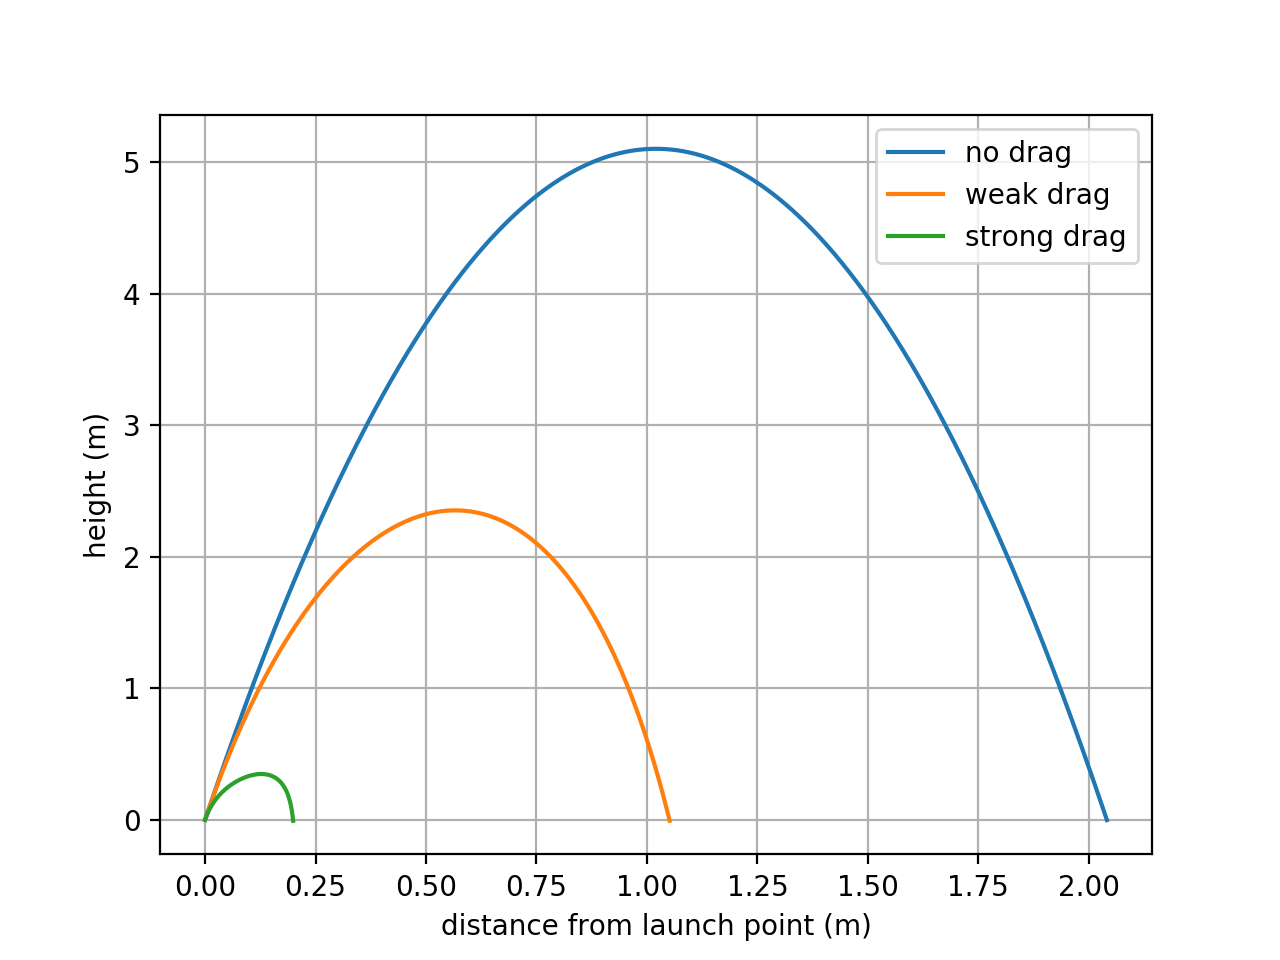

In [6]:
from spitfire.time.methods import ExplicitRungeKutta4Classical
import matplotlib.pyplot as plt

drag_coeff_dict = {'no drag': 0.0, 'weak drag': 0.01, 'strong drag': 0.2}

q0 = np.array([0., 0., 1., 10.])  # initial condition

%matplotlib notebook
for key in drag_coeff_dict:
    c_d = drag_coeff_dict[key]
    data = SaveAllDataToList(initial_solution=q0, initial_time=0., save_frequency=1)
    governor.custom_post_process_step = data.save_data

    governor.integrate(right_hand_side=lambda t, y: ode_rhs(t, y, c_d),
                       initial_condition=q0,
                       controller=1e-3,
                       method=ExplicitRungeKutta4Classical())
    plt.plot(data.solution_list[:, 0], data.solution_list[:, 1], label=key)

plt.xlabel('distance from launch point (m)')
plt.ylabel('height (m)')
plt.grid()
plt.legend(loc='best')
plt.show()

## Adaptive time-stepping

Above we had to guess at a value for the time step. Choosing a time step of one millisecond works well enough, but if we choose $\Delta t=0.1\,s$, which doesn't sound particularly unreasonable, the case with strong drag produces a nonsensical solution.

A key aspect of effective differential equation solvers is adaptive time-stepping, which is commonly (and in Spitfire) performed with error-control techniques. These techniques use embedded error estimation, meaning low-cast methods of assessing how accurate the solution is (locally). Methods for doing this exist in both linear multistep and Runge-Kutta methods.

Spitfire provides several methods with error estimates to enable adaptive time-stepping, for which a [PI controller](https://en.wikipedia.org/wiki/PID_controller) is available to adapt the time step to maintain the error near a particular target. Next we use the well-known `AdaptiveERK54CashKarp` method (see [https://en.wikipedia.org/wiki/Cash–Karp_method]) and the PI controller to solve the problem without having to choose an arbitrary time step. We do initialize the time step size to a guessed value, although this is typically far easier to do than pick a fixed step size for the entire simulation. We also explicitly provide the target error for the controller and a maximum step size in this case.

The trajectory plot shows that the solutions are at least reasonable and that the time step is varied quite differently per drag coefficient value.
In the drag-free case the time step simply ramps up to the maximum value, while the other cases see the step size decrease as the object is nearing the ground and the acceleration is increasing (higher $y$-velocity magnitude leading to stronger drag forces).

<IPython.core.display.Javascript object>


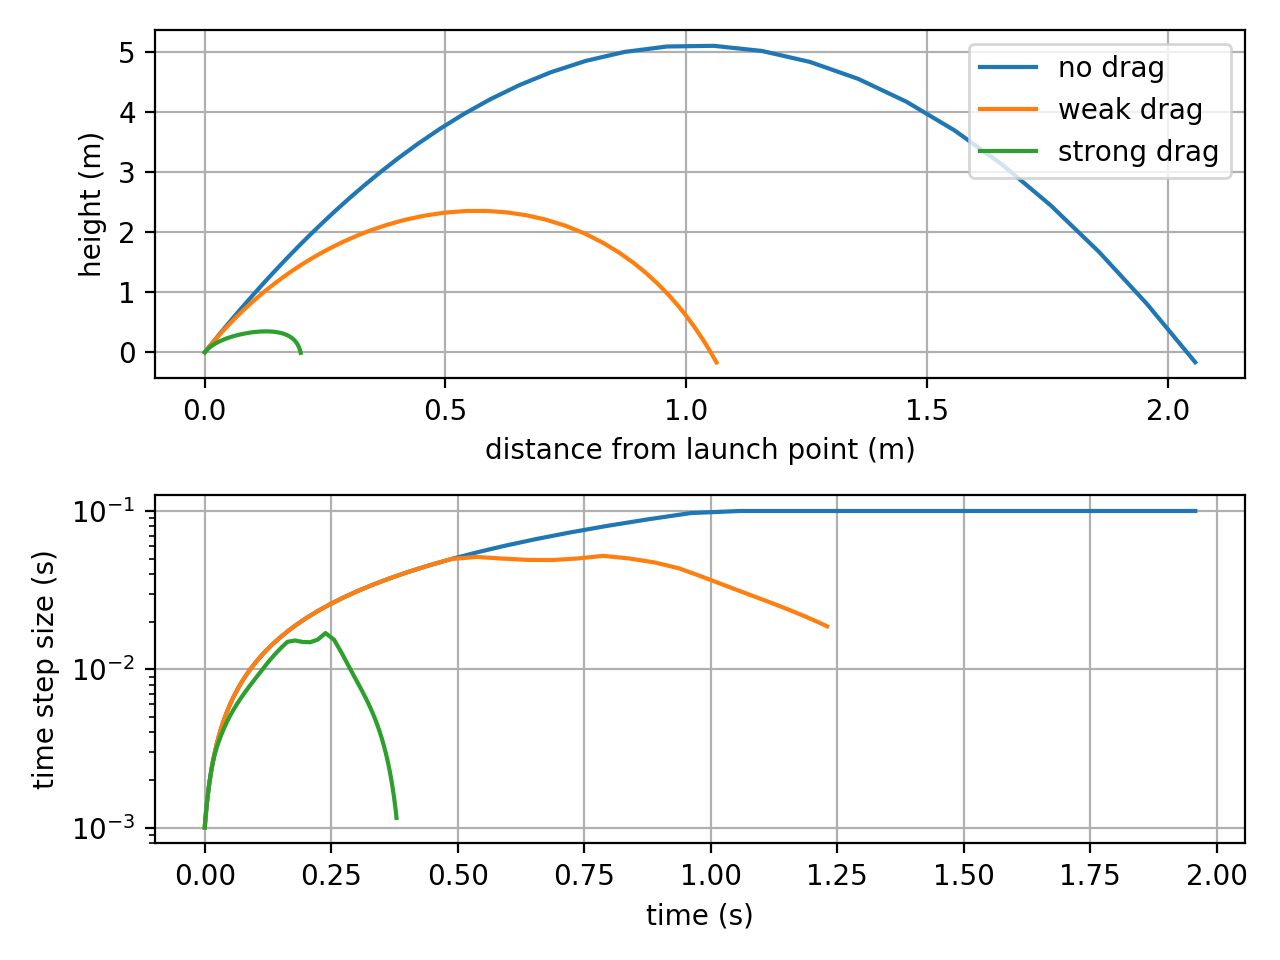

In [5]:
from spitfire.time.methods import AdaptiveERK54CashKarp
from spitfire.time.stepcontrol import PIController

%matplotlib notebook
figure, axarray = plt.subplots(2, 1)

for key in drag_coeff_dict:
    c_d = drag_coeff_dict[key]
    data = SaveAllDataToList(initial_solution=q0, initial_time=0., save_frequency=1)
    governor.custom_post_process_step = data.save_data

    governor.integrate(right_hand_side=lambda t, y: ode_rhs(t, y, c_d),
                       initial_condition=q0,
                       controller=PIController(target_error=1.e-8, first_step=1.e-3, max_step=1.e-1),
                       method=AdaptiveERK54CashKarp())
    t = data.t_list
    dt = t[1:] - t[:-1]
    axarray[0].plot(data.solution_list[:, 0], data.solution_list[:, 1], label=key)
    axarray[1].semilogy(t[:-1], dt)

axarray[0].set_xlabel('distance from launch point (m)')
axarray[0].set_ylabel('height (m)')
axarray[1].set_xlabel('time (s)')
axarray[1].set_ylabel('time step size (s)')
for ax in axarray:
    ax.grid()
axarray[0].legend(loc='best')
plt.tight_layout()
plt.show()

## Conclusion

This notebook has shown how to construct user-defined termination rules and use adaptive time-stepping to solve problems where simply guessing a fixed time step size or final simulation time are infeasible or inefficient. Adaptive time-stepping is helpful in solving nonlinear and stiff problems, and it is a key ingredient of Spitfire's solvers for complex chemistry problems that will be covered later.